In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Pretty display for notebooks
%matplotlib inline


In [22]:
#Parameters
data_directory = "./data/"
output_directory = "./out/"

input_file = "listings.csv"
file_coords_out = "neighbourhood_coordinates.csv"
file_ratings_out  = "neighbourhood_ratings.csv"

In [23]:
#Open data file
data_extended = pd.read_csv(data_directory + input_file)


In [24]:
pd.set_option('display.max_columns', 500)

In [25]:
data_extended.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,14842,https://www.airbnb.com/rooms/14842,20190122134607,2019-01-22,"Best location Portobello entire house, can sle...","Beautiful entire house, newly revamped, with s...","Gorgeous, newly revamped central Dublin city e...","Beautiful entire house, newly revamped, with s...",none,Portobello is an exceptional place to live - v...,NaN,"There is great public transport - buses, Luas,...",Guests get the whole house to themselves.,I love meeting guests and I give you extensive...,"This house is a charming space, just completel...",NaN,NaN,https://a0.muscache.com/im/pictures/106656330/...,NaN,58344,https://www.airbnb.com/users/show/58344,Hilary,2009-11-29,"Dublin, County Dublin, Ireland",An easy-going and friendly Irish woman. Works ...,within an hour,100%,NaN,t,https://a0.muscache.com/im/users/58344/profile...,https://a0.muscache.com/im/users/58344/profile...,NaN,1,1,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,"Dublin, Dublin City, Ireland",Portobello,Dublin City,NaN,Dublin,Dublin City,Dublin 8,Dublin,"Dublin, Ireland",IE,Ireland,53.331057,-6.269163,f,House,Entire home/apt,3,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,Heating,""Family/kid ...",0.0,$119.00,NaN,NaN,$500.00,$60.00,2,$30.00,20,31,20,20,31,31,20.0,31.0,3 days ago,t,2,2,5,5,2019-01-22,42,16,2011-07-11,2019-01-02,95.0,10.0,9.0,10.0,10.0,10.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.46


## Cleaning some of the input data

In [26]:
#Rename some of the longer names of neighbourhoods to facilate plotting later on a Tableau Map of the city 

data_extended['host_neighbourhood'].replace('Grafton Street/St. Stephens Green','St. Stephens Green', inplace=True)
data_extended['host_neighbourhood'].replace('North City Central/O\'Connell Street','North City Central', inplace=True)



In [27]:
#Clean up the price column
#1. Get rid of dollar signs and commas
#2. Convert to floats
#3. Investigate outliers

#1. Get rid of dollar signs and commas
#2. Convert to floats
data_extended['price'] = data_extended['price'].replace('[^.0-9]', '', regex=True).astype(float)

#3. Investigate outliers
#Looking at outliers greater than 1000 dollars per night: There are 6 of these. I get rid of all six because..
#Two have broken links. Can't guarantee their integrity
#Three were found to be erroneous prices somehow. 
#One was a correct listings (very fancy rental). However this will skew results in its neighbourhood as it's..
#price is significantly than anything else in Dublin.
#??I should really dig into some of the rentals in the 500 to 1000 dollar branket to investigate.
data_extended = data_extended[~(data_extended['price'] > 1000)]

## Helper Functions

In [28]:
def get_list_of_infrequent_values(data, min_freq=10):
    
    """
    Creates a list of the most infrequent values of a column. 

    Args:
        data: Series to be investigated.
        min_freq: Below this threshold value will be included in infrequent list (default = 10).
    
    Returns:
        A list of all infrequent values in data.
    """
    v_counts = data.value_counts()
    uncommon_list = list(v_counts[v_counts < min_freq].index)    
    return uncommon_list

## Get geographic coordinates for each neighbourhood

Geographic coordinates will be needed later when results are being plotted on a map of the city in Tableau. The method used here is to take all rental properties labelled with the neighbourhood in the database and to average both their latititude and their longitude. The averages are used as the cordinates for the neighbourhood.


In [29]:
#create a copy of the data_extended data.
data_coord = data_extended.copy()

In [30]:
#1. Remove rows that have NaN for neighbourhood and coordinates
data_coord.dropna(subset=['host_neighbourhood', 'latitude', 'longitude'], inplace=True)

In [31]:
#Get rid of neighbourhoods that dont have enough samples

#The min number of times the neighbourhood needs to feature in the list to be considered for comparision 
min_freq = 5

ignore_these_areas = get_list_of_infrequent_values(data_coord['host_neighbourhood'] , min_freq)
print(ignore_these_areas)

#get rid of the datapoints that are in the neigbourhoods to be ignored
data_coord_clean = data_coord[~data_coord['host_neighbourhood'].isin(ignore_these_areas)].copy()

#Remove a couple of specific neighbourhoods (ones that should not be included in the Dublin data)
data_coord_clean = data_coord_clean[~(data_coord_clean['host_neighbourhood'].isin(['Terézváros - District VI.', 'Isle of Dogs']))]

['Donnycarney', 'De Pijp', 'Grace Park', 'Ixelles', 'Opéra - Grands Boulevards', 'Kilmore', 'Oud-West', 'French Riviera', 'Downtown Montreal', 'Woluwe-Saint-Lambert', 'Saint-Germain-des-Prés - Odéon', 'Tour Eiffel - Champ de Mars', 'Fulham', 'Rose Bay/Dover Heights', 'Edenmore', 'West Village', 'Richmond District', 'Passy', 'Marine Parade', 'LB of Haringey', 'Auteuil', 'MLK & 183']


In [32]:
coord_groups = data_coord_clean[['latitude', 'longitude']].groupby(data_coord_clean['host_neighbourhood'])
coordinates = coord_groups.mean()

## Fill in missing values for neighbourhoods

Around 33% of the host neighbourhoods are missing. We can fill this data in by using the geographic coordinates caculated above to see which neighbourhood is nearest.

However, for this analysis, I consider the sample of 6362 rentals in Dublin to be sufficient for comparing average ratings in the different neighbourhoods.

In [230]:
data_extended.shape

(9511, 106)

In [231]:
data_extended['host_neighbourhood'].isna().sum()

3155

## What are the most expensive areas of the city to rent an Airbnb property?

The aim here is, for each neighbourhood, to break down the rentals into private rooms, single bed apartments, and 2 bed apartments. Then, for each of the 3 categories get an average. The average of these 3 averages will be used to represent the average cost of a rental for that area.

Neighbourhoods get dumped from the statistics if they dont have a minimum number of properties in the 3 categories mentioned above: private rooms, single bedroom house/apt and double bedroom house/apt. This is a bit rough as we are losing the oppurtunity to report on some of those neighbourhoods. Some form of imputing could have been considered when averaging the results if one of the categories was missing.


The get_average_per_neighbourhood() function can be used with the Airbnb data for any city. Data is available at the following location: http://insideairbnb.com/get-the-data.html.

In [33]:
def get_average_per_neighbourhood(city_data_listings, column, min_freq_of_neighbourhood ):
    """
    Gets the average value of ratings_column grouped by values of 'host_neighbourhood'. 

    Args:
        city_data_listings: Dataframe to be investigated.
        column: The column to get the average of.
        min_freq_of_neighbourhood: Below this threshold of frequency neighbourhoods will be removed(default = 10).
    Returns:
        Series of means for each neighbourhood in the dataset.
    """
    #The min number of times the neighbourhood needs to feature in the list to be considered for comparision 
    
    #create a copy of the data_extended data
    #and then this function will work on the data inplace
    city_data = city_data_listings.copy()
    
    #Remove rows that have NaN for neighbourhood
    city_data.dropna(subset=['host_neighbourhood'], inplace=True)

    #Remove rows that have NaN for Location Rating
    city_data.dropna(subset=[column], inplace=True) 
    
    #Get rid of neighbourhoods that dont have enough samples   
    ignore_these_areas = get_list_of_infrequent_values(city_data['host_neighbourhood'] , min_freq_of_neighbourhood)
    #print(ignore_these_areas)
    #get rid of the datapoints that are in the neigbourhoods to be ignored
    city_data = city_data[~city_data['host_neighbourhood'].isin(ignore_these_areas)]
    
    #Group the rentals into neighbourhoods and then get the means for each neighbourhood
    rating_groups = city_data[column].groupby(city_data['host_neighbourhood'])
    ratings = rating_groups.mean()
    
    return ratings


In [40]:
#Calculate the average price for 3 different datasets (one for each of the rental type categories that we are considering)
groups_privateroom = get_average_per_neighbourhood(data_extended[data_extended['room_type'] == 'Private room'], 'price', 5)
groups_entire_1bed = get_average_per_neighbourhood(data_extended[(data_extended['room_type'] == 'Entire home/apt') & (data_extended['bedrooms'] == 1.0)], 'price', 5)
groups_entire_2bed = get_average_per_neighbourhood(data_extended[(data_extended['room_type'] == 'Entire home/apt') & (data_extended['bedrooms'] == 2.0)], 'price', 5)


In [41]:
#Calculate an average across the 3 property types
averages = (groups_privateroom+ groups_entire_1bed + groups_entire_2bed)/3
#Remove some neighbourhoods that did not qualify for all three categories of rental
averages = averages.dropna()

averages.sort_values(ascending=False)

host_neighbourhood
Ballsbridge                   138.434360
Docklands                     137.522308
Trinity College               134.457321
Sandymount                    131.360534
Phibsborough                  126.096369
Georgian Quarter              124.525343
Drumcondra                    123.811240
St. Stephens Green            123.665263
Old City                      122.891443
North City Central            121.614253
Portobello                    119.925952
Temple Bar                    119.233926
Smithfield                    118.910385
The Liberties                 118.065387
East Wall                     117.465359
Ranelagh and Rathmines        113.199843
Rathgar                       110.921225
Ringsend/Irishtown            109.688937
North Strand                  106.368081
Stoneybatter/Arbour Hill      105.626848
Castleknock                   105.044995
Donnybrook                    104.509847
Monkstown                     101.964103
Phoenix Park and Surrounds     99.4333

## Which areas get the best average location rating score?

In [42]:
ratings = get_average_per_neighbourhood(data_extended, 'review_scores_location', 20)

In [49]:
#Write to a CSV file for export to facilite Tableau Map generation
#For each neighbourhood in the ratings table write
#1. The coordinates of the neighbourhood
#2. The ratings for that neighbourhood. 

#get list of all neighbourhoods in the list so we can search the coordinates dataframe for them.
neighbourhoods_of_interest = list(ratings.index)
#extract relevent coordinates
rating_coords = coordinates[ coordinates.index.isin(neighbourhoods_of_interest) ].copy()
#Combine ratings with the corordinates data
rating_coords['rating'] = ratings.values
#Write the ratings and coordinates to a file
rating_coords.to_csv(output_directory + file_ratings_out)

## Which rating correlates most strongly with overall score?


In [237]:
data_ratings = data_extended[['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                           'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']].copy()

In [238]:
data_ratings.shape

(9511, 7)

In [239]:
data_ratings.dropna(inplace=True)

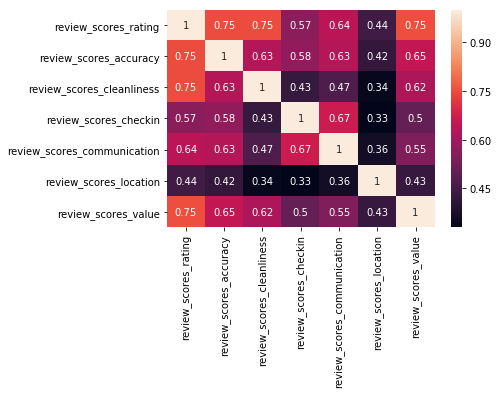

In [240]:
sns.heatmap( data_ratings.corr().abs(), annot=True)
